In [ ]:
! pip install transformers torchtext==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 16.6 MB/s 
     |████████████████████████████████| 7.6 MB 55.1 MB/s 
     |████████████████████████████████| 831.4 MB 14 kB/s 
     |████████████████████████████████| 7.6 MB 53.9 MB/s 
     |████████████████████████████████| 182 kB 80.5 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.13.0+cu116
    Uninstalling torch-1.13.0+cu116:
      Successfully uninstalled torch-1.13.0+cu116
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.14.0
    Uninstalling torchtext-0.14.0:
      Successfully uninstalled torchtext-0.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.14.0+cu116 requires torch==1.13.0, but you have torch 1.9.0 which is incompatible.
tor

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchtext
from torchtext import data
from torchtext import datasets
from torchtext.legacy import data
from torchtext.legacy import datasets

import transformers
from transformers import BertTokenizer, BertModel, BertForSequenceClassification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir("/content/drive/MyDrive/ECE1786/Project")

In [ ]:
! ls

 BERT_base.ipynb	       Final_Project_v2.ipynb
 BERT_base_v1.ipynb	      'flow chart.drawio'
 BERT_CNN_oversample.ipynb     GPT2.ipynb
 BERT_CNN_undersample.ipynb    model.drawio
 BERT_GRU.ipynb		       model.drawio（副本）
 Bert_GRU_v1.ipynb	       oversample_models
 data			       undersample_data
 data_preprocessing.ipynb      undersample_models
 data_preprocessing_v1.ipynb   Untitled0.ipynb
 Final_Project_v1.ipynb


# Tokenization

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

print(init_token, eos_token, pad_token, unk_token)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

[CLS] [SEP] [PAD] [UNK]


In [ ]:
init_token_idx = tokenizer.cls_token_id
eos_token_idx = tokenizer.sep_token_id
pad_token_idx = tokenizer.pad_token_id
unk_token_idx = tokenizer.unk_token_id
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']

In [ ]:
def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence) 
    tokens = tokens[:max_input_length-2]
    return tokens

In [ ]:
TEXT = data.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = tokenize_and_cut,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = init_token_idx,
                  eos_token = eos_token_idx,
                  pad_token = pad_token_idx,
                  unk_token = unk_token_idx)

In [ ]:
LABEL = data.LabelField(dtype = torch.float)

In [ ]:
def get_dataset():
    train, valid, test = data.TabularDataset.splits(path='data/', 
                                                    train='train.tsv', 
                                                    validation='validation.tsv',
                                                    test = 'test.tsv',
                                                    format = 'tsv', 
                                                    skip_header = True,
                                                    fields = [(None, None), ('text', TEXT),('label', LABEL)])
    return train, valid, test

In [ ]:
train_data, valid_data, test_data = get_dataset()

In [ ]:
# Check the train dataset tokenization
print(vars(train_data[1000]))

{'text': [2023, 18490, 2123, 2102, 2113, 2054, 2725, 2043, 3310, 2147], 'label': '2'}


In [ ]:
# Build vocabulary for labels
LABEL.build_vocab(train_data)

In [ ]:
print(LABEL.vocab.stoi)

defaultdict(None, {'0': 0, '1': 1, '2': 2})


In [ ]:
batch_size = 128

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    sort_key = lambda x: x.text, # sort key to minimize padding in training data
    sort = False, # dont sort test/validation data 
    batch_size=batch_size,
    device=device)

cuda


# Define the BERT model

In [ ]:
class BERT(nn.Module):
    def __init__(self, bert):
        super().__init__()
        hidden_dim = bert.config.to_dict()['hidden_size']
        self.bert = bert       
        self.out = nn.Linear(hidden_dim, 3)
        
    def forward(self, text):
        with torch.no_grad():
            embedded = self.bert(text)[0]

        output = self.out(torch.mean(embedded, 1))

        return output

In [ ]:
# BERT with MLP
bert_core = BertModel.from_pretrained('bert-base-uncased')
model = BERT(bert_core)
print(model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERT(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
       

In [ ]:
for name, param in model.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = False # freeze parameters

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,307 trainable parameters


# Define the helper functions and parameters

In [ ]:
N_EPOCHS = 20
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = torch.nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

def calculate_accuracy(preds, y):
    """
    returns accuracy per batch
    """
    class_preds = nn.Softmax(dim=-1)(preds)
    class_preds = class_preds.max(-1)[1]
    correct = (class_preds == y).float() # Convert into float for division
    acc = correct.sum() / len(correct)

    return acc

def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    
    for batch in iterator:
        batch.text = batch.text.to(device)
        optimizer.zero_grad()
        predictions = model(batch.text).squeeze(1).to(device)
        batch.label = batch.label.type(torch.LongTensor).to(device)
        #print(predictions.size())
        loss = criterion(predictions, batch.label)
        acc = calculate_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0

    # Output tensor for predicted labels
    output = torch.LongTensor([]).to(device)
    model.eval()
  
    with torch.no_grad():
        for batch in iterator:
            batch.text = batch.text.to(device)
            predictions = model(batch.text).squeeze(1).to(device)
            batch.label = batch.label.type(torch.LongTensor).to(device)

            # assign label according to the largest value
            class_preds = nn.Softmax(dim=-1)(predictions)
            class_preds = class_preds.max(-1)[1]
            
            # combine all the values in batches
            output = torch.cat((output, class_preds), 0)
            loss = criterion(predictions, batch.label)
            
            acc = calculate_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), output

In [ ]:
import time

# Print time between epochs
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# Train the model

In [ ]:
# Start training
best_valid_loss = float('inf')

train_loss_list = []
valid_loss_list = []
train_acc_list = []
valid_acc_list = []

for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc, output = evaluate(model, valid_iterator, criterion) 
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'picked_model.pt')
    
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    train_acc_list.append(train_acc)
    valid_acc_list.append(valid_acc)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 46s
	Train Loss: 1.038 | Train Acc: 50.80%
	 Val. Loss: 0.974 |  Val. Acc: 61.39%
Epoch: 02 | Epoch Time: 0m 45s
	Train Loss: 0.953 | Train Acc: 62.28%
	 Val. Loss: 0.895 |  Val. Acc: 68.09%
Epoch: 03 | Epoch Time: 0m 46s
	Train Loss: 0.895 | Train Acc: 67.12%
	 Val. Loss: 0.847 |  Val. Acc: 65.83%
Epoch: 04 | Epoch Time: 0m 46s
	Train Loss: 0.853 | Train Acc: 68.80%
	 Val. Loss: 0.806 |  Val. Acc: 69.51%
Epoch: 05 | Epoch Time: 0m 46s
	Train Loss: 0.820 | Train Acc: 70.33%
	 Val. Loss: 0.763 |  Val. Acc: 73.58%
Epoch: 06 | Epoch Time: 0m 46s
	Train Loss: 0.794 | Train Acc: 71.48%
	 Val. Loss: 0.745 |  Val. Acc: 72.33%
Epoch: 07 | Epoch Time: 0m 46s
	Train Loss: 0.773 | Train Acc: 71.75%
	 Val. Loss: 0.731 |  Val. Acc: 71.22%
Epoch: 08 | Epoch Time: 0m 46s
	Train Loss: 0.754 | Train Acc: 72.21%
	 Val. Loss: 0.707 |  Val. Acc: 74.10%
Epoch: 09 | Epoch Time: 0m 45s
	Train Loss: 0.742 | Train Acc: 72.27%
	 Val. Loss: 0.709 |  Val. Acc: 71.22%
Epoch: 10 | Epoch T

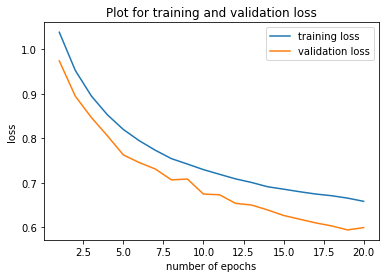

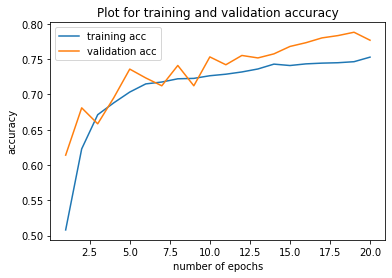

In [ ]:
fig = plt.figure()
plt.plot(range(1, N_EPOCHS+1), train_loss_list, label ='training loss')
plt.plot(range(1, N_EPOCHS+1), valid_loss_list, label ='validation loss')
plt.title("Plot for training and validation loss")
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(range(1, N_EPOCHS+1), train_acc_list, label ='training acc')
plt.plot(range(1, N_EPOCHS+1), valid_acc_list, label ='validation acc')
plt.title("Plot for training and validation accuracy")
plt.xlabel("number of epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

# Results for test set

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

model.load_state_dict(torch.load('picked_model.pt'))

# Output tensor for predicted labels
total_output = torch.LongTensor([]).to(device)
total_preds = torch.LongTensor([]).to(device)
model.eval()
with torch.no_grad():
    for batch in test_iterator:
        batch.text = batch.text.to(device)
        predictions = model(batch.text).squeeze(1).to(device)
        batch.label = batch.label.type(torch.LongTensor).to(device)

        # assign label according to the largest value
        class_preds = nn.Softmax(dim=-1)(predictions)
        class_preds = class_preds.max(-1)[1]

        total_output = torch.cat((total_output, batch.label), 0)
        total_preds = torch.cat((total_preds, class_preds), 0)

print(classification_report(total_output.cpu(), total_preds.cpu()))

              precision    recall  f1-score   support

           0       0.78      0.74      0.76      2000
           1       0.81      0.70      0.75      2000
           2       0.75      0.89      0.81      2000

    accuracy                           0.78      6000
   macro avg       0.78      0.78      0.77      6000
weighted avg       0.78      0.78      0.77      6000



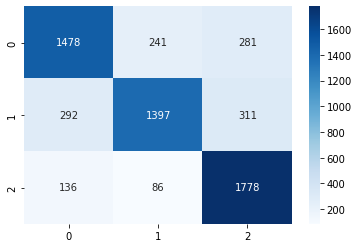

In [ ]:
sns.heatmap(confusion_matrix(total_output.cpu(), total_preds.cpu()), annot=True, fmt='.0f', cmap=plt.cm.Blues)
plt.show()